# ML model implementation
In this file, we implement different ML classification models to compare it with our Neural Network models (ANN and CNN).

We will run our ML classification models on two csv files. The 30 seconds csv file contains audio features over all of the audio, and 3 seconds csv contains audio feature at every 3 seconds intervals. 

In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

# importing some of our models and pipeline which will help us with performing GridSearch effciently.
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Importing some metrics that'll help us understand and visualize result
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()

## 30 seconds

In [2]:
df = pd.read_csv('./data/features_30_sec.csv')

# converting label columns into category data type
df['label'] = df["label"].astype('category')


# drop all the columns except for mfcc_mean 1-20
df1 = df.drop(df.iloc[:,:19],1)
df1 = df1.drop(df1.iloc[:,1::2],1)
# encode these labels
df1['label'] = df1["label"].cat.codes
df1.shape

(1000, 21)

In [3]:
df1.head()

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,label
0,-113.570648,121.571793,-19.168142,42.366421,-6.364664,18.623499,-13.704891,15.343150,-12.274110,10.976572,...,8.803792,-3.672300,5.747995,-5.162882,0.752740,-1.690215,-0.408979,-2.303523,1.221291,0
1,-207.501694,123.991264,8.955127,35.877647,2.907320,21.510466,-8.560436,23.370686,-10.099661,11.900497,...,5.376327,-2.231760,4.220140,-6.012148,0.927998,-0.731125,0.295073,-0.283518,0.531217,0
2,-90.722595,140.446304,-29.093889,31.684334,-13.984504,25.764742,-13.664875,11.639934,-11.783643,9.718760,...,5.791199,-8.907628,-1.077000,-9.229274,2.451690,-7.729093,-1.816407,-3.439720,-2.231258,0
3,-199.544205,150.090897,5.662678,26.859079,1.771399,14.234031,-4.832006,9.286494,-0.759186,8.137607,...,6.079319,-2.480174,-1.079305,-2.870789,0.780874,-3.319597,0.636965,-0.619121,-3.407448,0
4,-160.337708,126.219635,-35.587811,22.148071,-32.478600,10.852294,-23.352329,0.498434,-11.793437,1.207256,...,-2.813867,-6.933385,-7.552725,-9.164666,-4.520576,-5.454034,-0.916874,-4.404827,-11.703234,0


In [4]:
# shuffle the dataframe
df1 = df1.sample(frac=1, random_state=0)

In [5]:
# the data scale varies from one mfcc feature to another, so we will normalize it using 
# sklearn's statndardscaler

scaler = StandardScaler()
X = df1[df1.columns[~df1.columns.isin(['label'])]].to_numpy()
X = scaler.fit_transform(X)

y = df1['label'].to_numpy()

In [6]:
X.shape, y.shape

((1000, 20), (1000,))

In [7]:
# split the dataset, with 30% of dataset used for testing, 
# wih random state set to 0, to get same results on each run 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [8]:
# creating pipeline for our gridsearch
pipe = Pipeline(steps=[('classifier',LogisticRegression())])

# defining the models and their hyperparameters that'll be passed into GridSearchCV
param_grid=[
    {
        'classifier':[LogisticRegression()]
    },
    {
        'classifier':[GaussianNB()],
        'classifier__var_smoothing': [0.00000001, 0.000000001, 0.0000000001]

    },
    {     
        'classifier':[KNeighborsClassifier()],
        'classifier__metric':['euclidean','manhattan'],
        'classifier__n_neighbors':range(1,50)
    },
    {
        'classifier':[RandomForestClassifier()],
        'classifier__n_estimators':range(5,50,5),
        'classifier__criterion':['gini','entropy'],
        'classifier__max_features':['auto','sqrt','log2']
    },
    {
        'classifier':[DecisionTreeClassifier()],
        'classifier__criterion':['gini','entropy'],
        'classifier__max_features':['auto','sqrt','log2']       
    },
    {
        'classifier':[SVC()],
        'classifier__kernel':['linear', 'poly', 'rbf'],
        'classifier__gamma':[0.1, 1, 10, 100]
    }
    
]


clf = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = 'accuracy', n_jobs=-1, 
                   verbose = 2, cv = 10)

In [9]:
%%time
# fit and train our model
best = clf.fit(X_train,y_train)

Fitting 10 folds for each of 174 candidates, totalling 1740 fits
CPU times: user 2.26 s, sys: 213 ms, total: 2.47 s
Wall time: 43 s


In [10]:
# best model and it's hyperparameters
print(f'Our best model and params are {best.best_params_}')

Our best model and params are {'classifier': SVC(gamma=0.1), 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}


In [11]:
# accuracy score according to the best performing model
print(f'Our Best accurracy score is {round(best.best_score_*100,2)}%')

Our Best accurracy score is 61.57%


In [12]:
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.55      0.59        31
           1       0.83      0.97      0.89        30
           2       0.44      0.56      0.49        25
           3       0.53      0.55      0.54        29
           4       0.61      0.73      0.67        30
           5       0.54      0.44      0.48        34
           6       0.77      0.83      0.80        29
           7       0.74      0.77      0.75        30
           8       0.57      0.52      0.54        31
           9       0.55      0.39      0.45        31

    accuracy                           0.63       300
   macro avg       0.62      0.63      0.62       300
weighted avg       0.62      0.63      0.62       300



Text(48.453125, 0.5, 'True Labels')

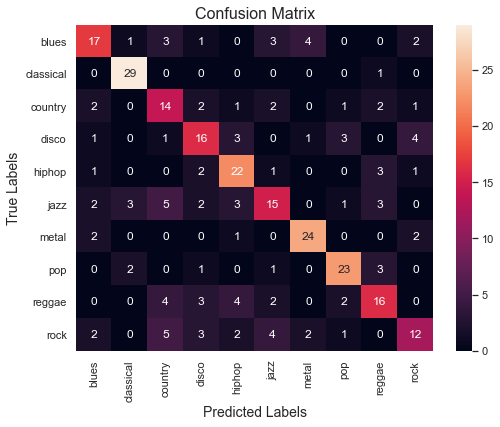

In [13]:
fig = plt.figure(figsize=(8, 6))

cfn_matrix = confusion_matrix(y_test, y_pred)

# for axis tick labels
ticks = df['label'].unique()


sns.heatmap(cfn_matrix, annot = True, xticklabels = ticks, yticklabels = ticks)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

## 3 Seconds

The steps we took in 30 seconds dataframe (or df dataframe), we repeat those same steps for 3 seconds csv/dataframe

In [14]:
df_short = pd.read_csv('./data/features_3_sec.csv')

# converting label columns into category data type
df_short['label'] = df_short["label"].astype('category')

# drop all the columns except for mfcc_mean 1-20
df_short1 = df_short.drop(df_short.iloc[:,:19],1)
df_short1 = df_short1.drop(df_short1.iloc[:,1::2],1)

# encode these labels
df_short1['label'] = df_short1["label"].cat.codes

In [15]:
# shuffle data
df_short1 = df_short1.sample(frac=1, random_state=0)

In [16]:
# normalizing the data
scaler = StandardScaler()

X_short = df_short1[df_short1.columns[~df_short1.columns.isin(['label'])]].to_numpy()
X_short = scaler.fit_transform(X_short)

y_short = df_short1['label'].to_numpy()

In [17]:
X_short.shape, y_short.shape

((9990, 20), (9990,))

In [18]:
# splitting dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_short, y_short, test_size=0.30, random_state=0)

In [19]:
%%time
# fitting our new data for training into our gridsearch
best1 = clf.fit(X_train1, y_train1)

Fitting 10 folds for each of 174 candidates, totalling 1740 fits
CPU times: user 3.86 s, sys: 555 ms, total: 4.42 s
Wall time: 9min 11s


In [20]:
# best performing models and its hyperparameters
print(f'Our best model and params are {best1.best_params_}')

Our best model and params are {'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 1}


In [21]:
# accuracy score according to the best performing model
print(f'Our Best accurracy score is {round(best1.best_score_*100,2)}%')

Our Best accurracy score is 85.17%


In [22]:
y_pred1 = best.predict(X_test1)
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       312
           1       0.90      0.93      0.91       275
           2       0.82      0.75      0.78       280
           3       0.82      0.85      0.83       290
           4       0.89      0.88      0.89       319
           5       0.83      0.84      0.84       302
           6       0.92      0.96      0.94       320
           7       0.90      0.88      0.89       307
           8       0.87      0.87      0.87       311
           9       0.78      0.81      0.80       281

    accuracy                           0.87      2997
   macro avg       0.87      0.87      0.87      2997
weighted avg       0.87      0.87      0.87      2997



Text(48.453125, 0.5, 'True Labels')

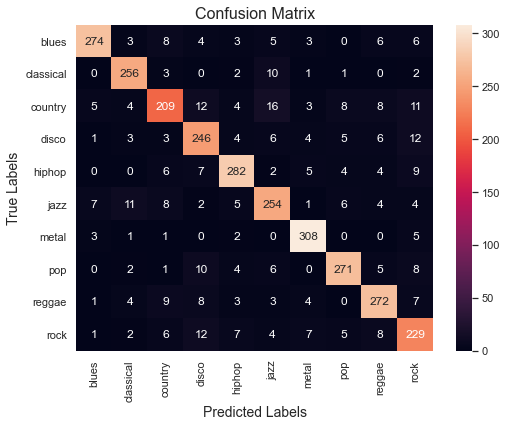

In [23]:
# confusion matrix of 3 seconds dataframe
fig = plt.figure(figsize=(8, 6))
cfn_matrix1 = confusion_matrix(y_test1, y_pred1)

sns.heatmap(cfn_matrix1, annot = True, xticklabels = ticks, yticklabels = ticks, fmt="d")
plt.title('Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted Labels', fontsize = 14)
plt.ylabel('True Labels', fontsize = 14)